# Importando bibliotecas

In [220]:
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn           as sns

# Padrão de cores seaborn

In [221]:
sns.set_theme()

# Funções para auxiliar na manipulação

In [222]:
def dec_to_bin(num, mem_size=13):
    initial = '0'*(mem_size - len(bin(num).replace('0b', ''))) # preenche com 0 'casas iniciais'
    
    return (initial + bin(num).replace('0b', ''))

def bin_to_dec(num):
    return int(num, base=2)

def decompose(address, tag_size, line_size):
    return {
        'Tag':  address[ : tag_size],                        # [0, tag_size)
        'Line': address[tag_size : line_size + tag_size],    # [tag_size, line_size + tag_size)
        'Word': address[line_size + tag_size : len(address)] # [line_size + tag_size, len(address))
    }

# Aquisição de endereços

In [223]:
main_memory = pd.read_csv('https://raw.githubusercontent.com/DinizMaths/ArqComp/main/Cache%20Simulation/enderecos.dat', sep='::', engine='python', header=None).rename(columns = {0: 'enderecos'})

main_memory

,enderecos
0,0
1,1
2,2
3,3
4,4
...,...
11695,6719
11696,6720
11697,6721
11698,6722


In [224]:
len(main_memory['enderecos'].unique())

6724

# Simulações

## Memória com mapeamento direto

In [225]:
main_memory_bin = pd.DataFrame([decompose(address, 3, 8) for address in main_memory['enderecos'].map(dec_to_bin)])

main_memory_bin

,Tag,Line,Word
0,000,00000000,00
1,000,00000000,01
2,000,00000000,10
3,000,00000000,11
4,000,00000001,00
...,...,...,...
11695,110,10001111,11
11696,110,10010000,00
11697,110,10010000,01
11698,110,10010000,10


In [226]:
cache = pd.DataFrame([np.nan] * 256, columns=['Tag'])

cache

,Tag
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
251,NaN
252,NaN
253,NaN
254,NaN


In [227]:
hit  = 0
miss = 0

for memory_line in range(len(main_memory_bin)):
    cache_line = bin_to_dec(main_memory_bin.iloc[memory_line]['Line'])
    
    if cache['Tag'].iloc[cache_line] == main_memory_bin.iloc[memory_line]['Tag']:
        hit += 1
    else:
        cache['Tag'].iloc[cache_line] = main_memory_bin.iloc[memory_line]['Tag']
        miss += 1

In [228]:
print('=' * 25)
print(f'Total de acessos: {hit + miss}')
print(f'Total de acertos: {hit}')
print(f'Total de erros: {miss}')
print('=' * 25)

Total de acessos: 11700
Total de acertos: 10019
Total de erros: 1681


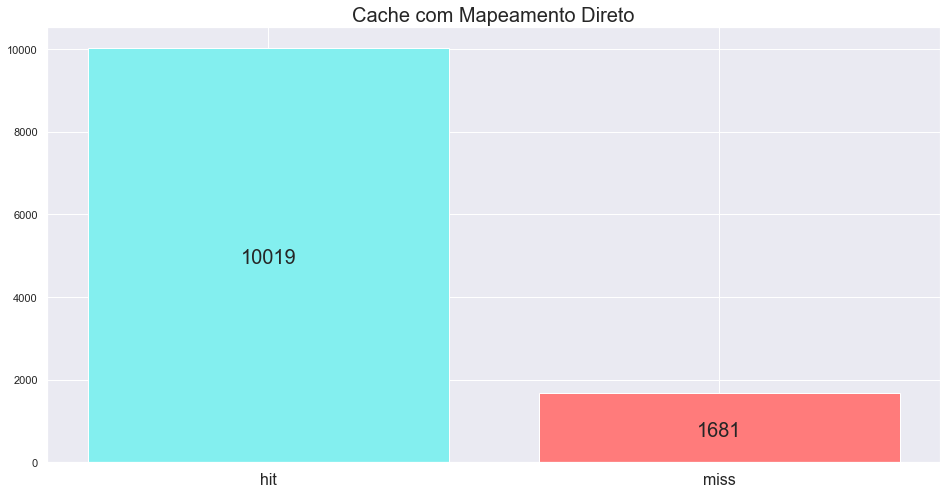

In [229]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(['hit', 'miss'], [hit, miss], color=['#83EFEF', '#FF7B7B'])

ax.text('hit', hit/2-200, hit, ha='center', size=20)
ax.text('miss', miss/2-200, miss, ha='center', size=20)
ax.set_title('Cache com Mapeamento Direto', fontsize=20)

plt.xticks(fontsize=16)
plt.show()

## Memória com mapeamento associativo em conjunto de 2 vias

In [230]:
main_memory_bin = pd.DataFrame([decompose(address, 4, 7) for address in main_memory['enderecos'].map(dec_to_bin)])

main_memory_bin

,Tag,Line,Word
0,0000,0000000,00
1,0000,0000000,01
2,0000,0000000,10
3,0000,0000000,11
4,0000,0000001,00
...,...,...,...
11695,1101,0001111,11
11696,1101,0010000,00
11697,1101,0010000,01
11698,1101,0010000,10


In [231]:
cache = pd.DataFrame([[0, np.nan, 0, np.nan]] * 128 * 2, columns=pd.MultiIndex.from_product([['Set0', 'Set1'], ['RefBit', 'Tag']]))

cache

Set0       Set1    
    RefBit Tag RefBit Tag
0        0 NaN      0 NaN
1        0 NaN      0 NaN
2        0 NaN      0 NaN
3        0 NaN      0 NaN
4        0 NaN      0 NaN
..     ...  ..    ...  ..
251      0 NaN      0 NaN
252      0 NaN      0 NaN
253      0 NaN      0 NaN
254      0 NaN      0 NaN
255      0 NaN      0 NaN

[256 rows x 4 columns]

In [232]:
hit  = 0
miss = 0

for memory_line in range(len(main_memory_bin)):
    cache_set = bin_to_dec(main_memory_bin.iloc[memory_line]['Line'])
    tag = main_memory_bin.iloc[memory_line]['Tag']
    
    if cache.loc[cache_set, ('Set0', 'Tag')] == tag:
        cache.loc[cache_set, ('Set0', 'RefBit')] = 1
        hit += 1
        
    elif cache.loc[cache_set, ('Set1', 'Tag')] == tag:
        cache.loc[cache_set, ('Set1', 'RefBit')] = 1
        hit += 1
    
    elif cache.loc[cache_set, ('Set0', 'RefBit')] == 0:
        cache.loc[cache_set, ('Set0', 'Tag')] = tag
        cache.loc[cache_set, ('Set0', 'RefBit')] = 1
        cache.loc[cache_set, ('Set1', 'RefBit')] = 0
        miss += 1
        
    else:
        cache.loc[cache_set, ('Set1', 'Tag')] = tag
        cache.loc[cache_set, ('Set1', 'RefBit')] = 1
        cache.loc[cache_set, ('Set0', 'RefBit')] = 0
        miss += 1

In [233]:
print('=' * 25)
print(f'Total de acessos: {hit + miss}')
print(f'Total de acertos: {hit}')
print(f'Total de erros: {miss}')
print('=' * 25)

Total de acessos: 11700
Total de acertos: 10019
Total de erros: 1681


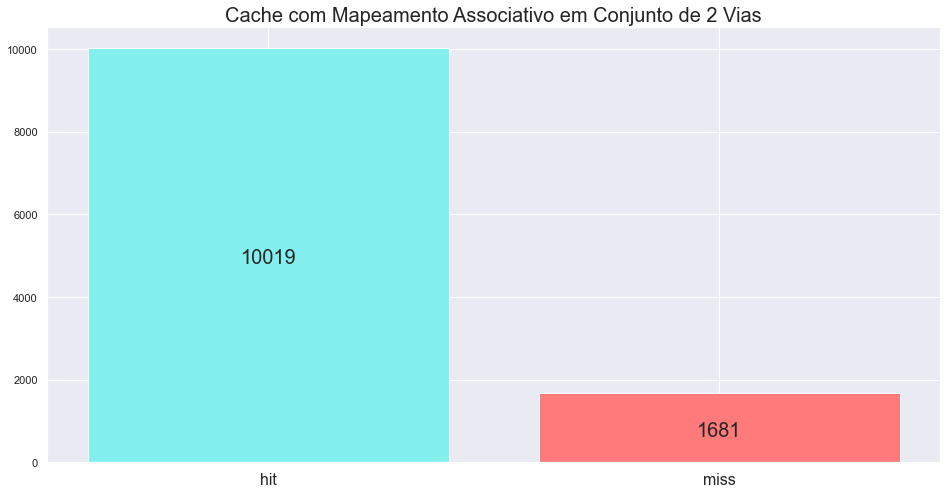

In [235]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(['hit', 'miss'], [hit, miss], color=['#83EFEF', '#FF7B7B'])

ax.text('hit', hit/2-200, hit, ha='center', size=20)
ax.text('miss', miss/2-200, miss, ha='center', size=20)
ax.set_title('Cache com Mapeamento Associativo em Conjunto de 2 Vias', fontsize=20)

plt.xticks(fontsize=16)
plt.show()